In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [61]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.13.0


In [59]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [62]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [63]:
dataset.isna().sum()
dataset = dataset.dropna()

In [64]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA


In [65]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [66]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [ ]:
train_dataset.describe().transpose()

In [67]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [68]:
train_features

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

In [69]:
normalizer = tf.keras.layers.Normalization(axis=-1) # create the layer, -1 in this context just means the last axis
normalizer.adapt(np.array(train_features)) # fit the state of the preprocessing layer to the data 
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [70]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [71]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [72]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_5 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [73]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 39ms/step


array([[ 1.019],
       [ 0.575],
       [-1.88 ],
       [ 1.428],
       [ 1.291],
       [ 0.507],
       [ 1.53 ],
       [ 1.291],
       [ 0.337],
       [ 0.575]], dtype=float32)

In [74]:
def custom_loss(y_true, y_pred):
    # Calculate the loss
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return loss

horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')#=custom_loss) # 'mean_absolute_error'

In [75]:
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [77]:
hist = pd.DataFrame(history.history) # history.history 就是loss
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.808592,4.160522,95
96,3.807216,4.159423,96
97,3.805465,4.171533,97
98,3.801126,4.200751,98
99,3.808048,4.205642,99


In [79]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

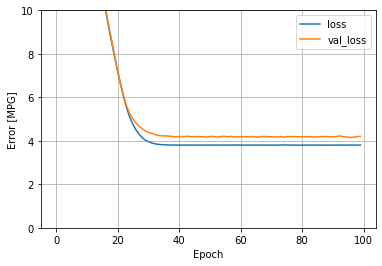

In [80]:
plot_loss(history)

In [81]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [82]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 1ms/step


In [83]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

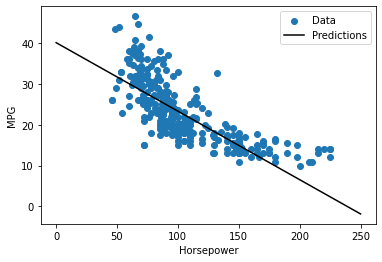

In [84]:
plot_horsepower(x, y)

### Linear regression with multiple inputs

In [85]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [86]:
train_features[:10]

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
257,6,232.0,90.0,3210.0,17.2,78,0,0,1
310,4,89.0,60.0,1968.0,18.8,80,0,1,0
328,4,146.0,67.0,3250.0,21.8,80,1,0,0
125,6,198.0,95.0,3102.0,16.5,74,0,0,1
108,4,97.0,88.0,2279.0,19.0,73,0,1,0


In [87]:
linear_model.predict(train_features[:10]) # 10 rows

1/1 [==============================] - 0s 39ms/step


array([[ 1.297],
       [ 0.479],
       [-0.178],
       [ 0.817],
       [-1.313],
       [-0.461],
       [-1.497],
       [-0.309],
       [ 0.05 ],
       [-1.152]], dtype=float32)

In [88]:
linear_model.layers[1].kernel # 9 weight

<tf.Variable 'dense_6/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.388],
       [-0.743],
       [ 0.095],
       [ 0.29 ],
       [-0.565],
       [-0.139],
       [ 0.181],
       [-0.506],
       [ 0.165]], dtype=float32)>

In [89]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [90]:
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

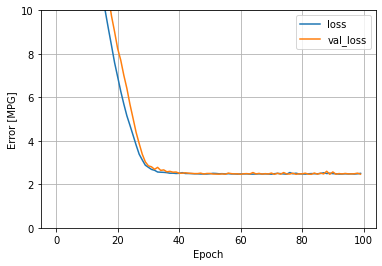

In [91]:
plot_loss(history)

In [104]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

### Regression with a deep neural network (DNN)

In [94]:
def build_and_compile_model(normalizer):
  model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu'), #  ReLU (relu) activation function nonlinearity.
      layers.Dense(64, activation='relu'),
      layers.Dense(1) #  linear Dense single-output layer.
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [95]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)
dnn_horsepower_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_7 (Dense)             (None, 64)                128       
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4356 (17.02 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [96]:
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

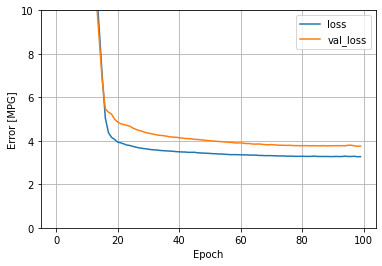

In [97]:
plot_loss(history)

In [100]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 1ms/step


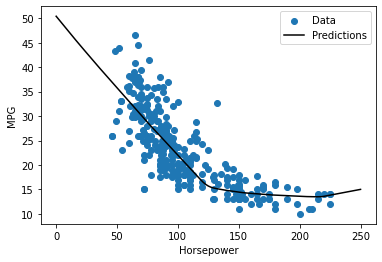

In [101]:
plot_horsepower(x, y)

In [102]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [105]:
test_results

{'horsepower_model': 3.6608073711395264,
 'dnn_horsepower_model': 2.956820487976074,
 'linear_model': 2.4713850021362305}

#### Regression using a DNN and multiple inputs

In [106]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normaliza  (None, 9)                 19        
 tion)                                                           
                                                                 
 dense_10 (Dense)            (None, 64)                640       
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4884 (19.08 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


In [107]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

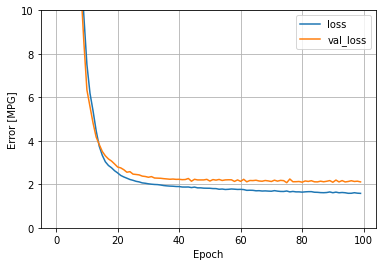

In [108]:
plot_loss(history)

In [109]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [110]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.660807
dnn_horsepower_model,2.956820
linear_model,2.471385
dnn_model,1.741294


### Make predictions

3/3 [==============================] - 0s 2ms/step


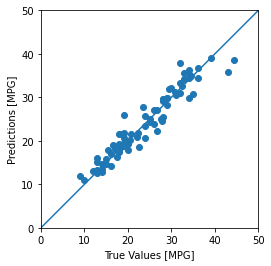

In [113]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

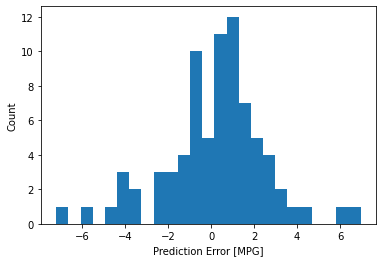

In [114]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')